# Theano, Lasagne
и с чем их едят

# разминка
* напиши на numpy функцию, которая считает сумму квадратов чисел от 0 до N, где N - аргумент
* массив чисел от 0 до N - numpy.arange(N)

In [ ]:
!pip install Theano
!pip install lasagne

In [1]:
import numpy as np

def sum_squares(N):
    return np.square(np.arange(N)).sum()

In [6]:
%%time
sum_squares(10**8)

CPU times: user 428 ms, sys: 712 ms, total: 1.14 s
Wall time: 1.31 s


662921401752298880

# theano teaser

Как сделать то же самое

In [2]:
import theano
import theano.tensor as T

In [8]:
#будущий параметр функции
N = T.scalar("a dimension",dtype='int32')

#рецепт получения суммы квадратов
result = (T.arange(N)**2).sum()

#компиляция функции "сумма квадратов" чисел от 0 до N
sum_function = theano.function(inputs=[N], outputs=result)

In [9]:
%%time
sum_function(10**8)

CPU times: user 360 ms, sys: 104 ms, total: 464 ms
Wall time: 461 ms


array(662921401752298880)

# Как оно работает?
* Нужно написать "рецепт" получения выходов по входам
* То же самое на заумном: нужно описать символический граф вычислений


* 2 вида зверей - "входы" и "преобразования"
* Оба могут быть числами, массивами, матрицами, тензорами и т.п.


* Вход - это то аргумент функции. То место, на которое подставится аргумент вызове.
 * N - вход в примере выше


* Преобразования - рецепты вычисления чего-то на основе входов и констант
 * (T.arange(N)^2).sum() - 3 последовательных преобразования N
 * Работают почти 1 в 1 как векторные операции в numpy
 * почти всё, что есть в numpy есть в theano tensor и называется так же
   * np.mean -> T.mean
   * np.arange -> T.arange
   * np.cumsum -> T.cumsum
   * и так далее...
   * Совсем редко - бывает, что меняется название или синтаксис - нужно спросить у семинаристов или гугла
 
 
Ничего не понятно? Сейчас исправим.

In [11]:
#входы
example_input_integer = T.scalar('вход - одно число(пример)', dtype='float32')

example_input_tensor = T.tensor4('вход - четырёхмерный тензор(пример)')
#не бойся, тензор нам не пригодится

input_vector = T.vector('вход - вектор целых чисел', dtype='int32')

In [12]:
#преобразования

#поэлементное умножение
double_the_vector = input_vector*2

#поэлементный косинус
elementwise_cosine = T.cos(input_vector)

#разность квадрата каждого элемента и самого элемента
vector_squares = input_vector**2 - input_vector

In [13]:
double_the_vector

Elemwise{mul,no_inplace}.0

In [21]:
#теперь сам:
#создай 2 вектора из чисел float32
my_vector = T.vector('input vector 1', dtype='float32') #<вектор из float32>
my_vector2 = T.vector('input vector 2', dtype='float32') #<ещё один такой же>

In [22]:
#напиши преобразование, которое считает
#(вектор 1)*(вектор 2) / (sin(вектор 1) +1)
my_transformation = my_vector * my_vector2 / (T.sin(my_vector) + 1) #<преобразование>

In [23]:
print(my_transformation)
#то, что получилась не чиселка - это нормально

Elemwise{true_div,no_inplace}.0


# Компиляция
* До этого момента, мы использовали "символические" переменные
 * писали рецепт вычислений, но ничего не вычисляли
* чтобы рецепт можно было использовать, его нужно скомпилировать

In [24]:
inputs = [my_vector, my_vector2] #[<от чего завсит функция>]
outputs = [my_transformation] #[<что вычисляет функция (можно сразу несколько - списком, либо 1 преобразование)>]

# можно скомпилировать написанные нами преобразования как функцию
my_function = theano.function(
    inputs, outputs,
    allow_input_downcast=True #автоматически прводить типы (необязательно)
 )

In [25]:
#можно вызвать вот-так:
print('using python lists: ')
print(my_function([1,2,3], [4,5,6]))
print()

#а можно так. 
#К слову, ту тип float приводится к типу второго вектора
print('using numpy arrays: ')
print(my_function(np.arange(10),
                  np.linspace(5, 6, 10, dtype='float')))

using python lists: 
[array([  2.1721766 ,   5.23752832,  15.77397728], dtype=float32)]

using numpy arrays: 
[array([   0.        ,    2.77555895,    5.47030783,   14.02131271,
         89.5477066 ,  676.25805664,   47.183918  ,   24.4084301 ,
         23.68156242,   38.24041748], dtype=float32)]


# хинт для отладки
* Если ваша функция большая, компиляция может отнять какое-то время.
* Чтобы не ждать, можно посчитать выражение без компиляции
* Вы экономите время 1 раз на компиляции, но сам код выполняется медленнее


In [27]:
#словарик значений для входов
my_function_inputs = {
    my_vector: [1, 2, 3],
    my_vector2: [4, 5, 6]
}

#вычислить без компиляции
#если мы ничего не перепутали, 
#должно получиться точно то же, что и раньше
print(my_transformation.eval(my_function_inputs))


#можно вычислять преобразования на ходу
print('сумма 2 векторов', (my_vector + my_vector2).eval(my_function_inputs))

#!ВАЖНО! если преобразование зависит только от части переменных,
#остальные давать не надо
print('форма первого вектора', my_vector.shape.eval({
        my_vector: [1, 2, 3]
}))

[  2.1721766    5.23752832  15.77397728]
сумма 2 векторов [ 5.  7.  9.]
форма первого вектора [3]


* Для отладки желательно уменьшить масштаб задачи. Если вы планировали послать на вход вектор из 10^9 примеров, пошлите 10~100.
* Если #ОЧЕНЬ нужно послать большой вектор, быстрее скомпилировать функцию обычным способом

# Теперь сам

In [21]:
# Задание 1 - напиши и скомпилируй theano-функцию, которая считает среднеквадратичную ошибку двух векторов-входов
# Вернуть нужно одно число - собственно, ошибку. Обновлять ничего не нужно

# <твой код - входы и преобразования>
input_vector_1 = T.vector(name='Input vector 1', dtype='float64')
input_vector_2 = T.vector(name='Input vector 2', dtype='float64')
res = T.sum(T.sqr((input_vector_1 - input_vector_2))) / input_vector_1.size

compute_mse = theano.function(inputs=[input_vector_1, input_vector_2], outputs=res) #<твой код - компиляция функции>

In [22]:
# тесты
from sklearn.metrics import mean_squared_error

for n in [1,5,10,10**3]:
    
    elems = [np.arange(n), np.arange(n,0,-1), np.zeros(n),
             np.ones(n), np.random.random(n), np.random.randint(100, size=n)]
    
    for el in elems:
        for el_2 in elems:
            true_mse = np.array(mean_squared_error(el, el_2))
            my_mse = compute_mse(el, el_2)
            if not np.allclose(true_mse, my_mse):
                print('Wrong result:')
                print('mse(%s,%s)' % (el, el_2))
                print('should be: %f, but your function returned %f' % (true_mse, my_mse))
                raise ValueError('Что-то не так')

print('All tests passed')

All tests passed


# Shared variables

* Входы и преобразования - части рецепта. 
 * Они существуют только во время вызова функции.


* Shared переменные - всегда остаются в памяти
 * им можно поменять значение 
   * (но не внутри символического графа. Об этом позже)
 * их можно включить в граф вычислений
 
 
* хинт - в таких переменных удобно хранить параметры и гиперпараметры
 * например, веса нейронки или learning rate, если вы его меняете

In [23]:
#cоздадим расшаренную перменную
shared_vector_1 = theano.shared(np.ones(10, dtype='float64'))

In [24]:
#получить (численное) значение переменной
print('initial value', shared_vector_1.get_value())

initial value [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


In [25]:
#задать новое значение
shared_vector_1.set_value(np.arange(5))

#проверим значение
print('new value', shared_vector_1.get_value())

#Заметь, что раньше это был вектор из 10 элементов, а сейчас - из 5. 
#Если граф при этом остался выполним, это сработает.

new value [ 0.  1.  2.  3.  4.]


# Теперь сам

In [27]:
#напиши рецепт (преобразование), которое считает произведение(поэллементное) shared_vector на input_scalar
#скомпилируй это в функцию от input_scalar

input_scalar = T.scalar('coefficient', dtype='float32')

scalar_times_shared = input_scalar * shared_vector_1 # <рецепт тут>

# <твой код, который компилирует функцию>
shared_times_n = theano.function(inputs=[input_scalar], outputs=scalar_times_shared)

In [29]:
print('shared: ', shared_vector_1.get_value())
print('shared_times_n(5)' , shared_times_n(5))
print('shared_times_n(-0.5)', shared_times_n(-0.5))

shared:  [ 0.  1.  2.  3.  4.]
shared_times_n(5) [  0.   5.  10.  15.  20.]
shared_times_n(-0.5) [-0.  -0.5 -1.  -1.5 -2. ]


In [30]:
#поменяем значение shared_vector_1
shared_vector_1.set_value([-1, 0, 1])
print('shared: ', shared_vector_1.get_value())
print('shared_times_n(5): ',shared_times_n(5))
print('shared_times_n(-0.5)' ,shared_times_n(-0.5))

shared:  [-1.  0.  1.]
shared_times_n(5):  [-5.  0.  5.]
shared_times_n(-0.5) [ 0.5 -0.  -0.5]


# T.grad, самое вкусное
* theano умеет само считать производные. Все, которые существуют.
* Производные считаются в символическом, а не численном виде

Ограничения
* За раз можно считать производную __скалярной__ функции по одной или нескольким скалярным или векторным аргументам
* Функция должна на всех этапах своего вычисления иметь тип float32 или float64 (т.к. на множестве целых чисел производная не имеет смысл)

In [31]:
my_scalar = T.scalar(name='input', dtype='float64')

scalar_squared = T.sum(my_scalar**2)

#производная v_squared по my_vector
derivative = T.grad(scalar_squared, my_scalar)

fun = theano.function([my_scalar], scalar_squared)
grad = theano.function([my_scalar], derivative) 

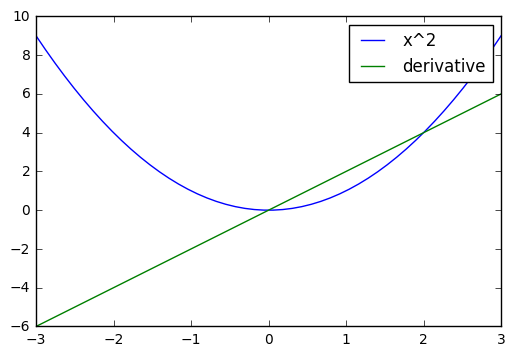

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline


x = np.linspace(-3,3)
x_squared = map(fun,x)
x_squared_der = map(grad,x)

plt.plot(x, list(x_squared), label='x^2')
plt.plot(x, list(x_squared_der), label='derivative')
plt.legend()
plt.show()

# теперь сам

In [37]:
my_vector = T.vector('float64')

#посчитай производные этой функции по my_scalar и my_vector
#warning! Не пытайся понять физический смысл этой функции
weird_psychotic_function = ((my_vector + my_scalar)**(1 + T.var(my_vector)) + 1. / T.arcsinh(my_scalar)).mean() \
    / (my_scalar**2 + 1) + 0.01 * T.sin(2 * my_scalar**1.5) * (T.sum(my_vector) *my_scalar**2) * T.exp((my_scalar-4)**2) \
    / (1 + T.exp((my_scalar - 4)**2)) * (1. - (T.exp( - (my_scalar - 4)**2)) / (1 + T.exp( - (my_scalar - 4)**2)))**2

# градиент функции сверху по скаляру и вектору (можно дать списком)
der_by_scalar = theano.grad(weird_psychotic_function, my_scalar)
der_by_vector = theano.grad(weird_psychotic_function, my_vector)

compute_weird_function = theano.function([my_scalar, my_vector], weird_psychotic_function)
compute_der_by_scalar = theano.function([my_scalar, my_vector], der_by_scalar)

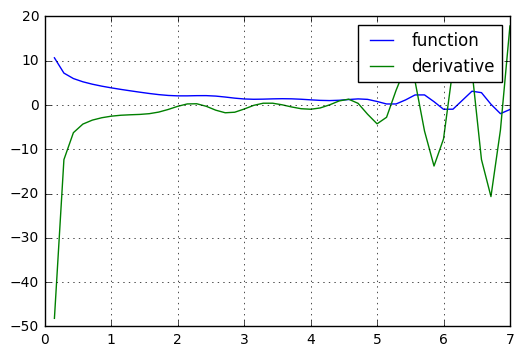

In [38]:
#график функции и твоей производной
vector_0 = [1, 2, 3]

scalar_space = np.linspace(0, 7)

y = [compute_weird_function(x, vector_0) for x in scalar_space]
plt.plot(scalar_space, y, label='function')
y_der_by_scalar = [compute_der_by_scalar(x, vector_0) for x in scalar_space]
plt.plot(scalar_space, y_der_by_scalar, label='derivative')
plt.grid()
plt.legend()
plt.show()

# Последний штрих - Updates

* updates - это способ изменять значения shared переменных каждый раз В КОНЦЕ вызова функции

* фактически, это словарь {shared_переменная: рецепт нового значения}, который добавляется в функцию при компиляции

Например,

In [39]:
#умножим shared вектор на число и сохраним новое значение обратно в этот shared вектор

inputs = [input_scalar]
outputs = [scalar_times_shared] #вернём вектор, умноженный на число

my_updates = {
    shared_vector_1: scalar_times_shared #и этот же результат запишем в shared_vector_1
}

compute_and_save = theano.function(inputs, outputs, updates=my_updates)

In [40]:
shared_vector_1.set_value(np.arange(5))

#изначальное значение shared_vector_1
print('initial shared value: ', shared_vector_1.get_value())

# теперь вычислим функцию (значение shared_vector_1 при этом поменяется)
print('compute_and_save(2) returns', compute_and_save(2))

#проверим, что в shared_vector_1
print('new shared value: ', shared_vector_1.get_value())

initial shared value:  [ 0.  1.  2.  3.  4.]
compute_and_save(2) returns [array([ 0.,  2.,  4.,  6.,  8.])]
new shared value:  [ 0.  2.  4.  6.  8.]


# Логистическая регрессия
Что нам потребуется:
* Веса лучше хранить в shared-переменной
* Данные можно передавать как input
* Нужно 2 функции:
 * train_function(X,y) - возвращает ошибку и изменяет веса на 1 шаг по граиденту __(через updates)__
 * predict_fun(X) - возвращает предсказанные ответы ("y") по данным

In [50]:
from sklearn.datasets import load_digits
mnist = load_digits(2)

X,y = mnist.data, mnist.target

print('y [форма - %s]: ' % (str(y.shape)), y[:10])
print('X [форма - %s]: ' % (str(X.shape)))
print(X[:3])

y [форма - (360,)]:  [0 1 0 1 0 1 0 0 1 1]
X [форма - (360, 64)]: 
[[  0.   0.   5.  13.   9.   1.   0.   0.   0.   0.  13.  15.  10.  15.
    5.   0.   0.   3.  15.   2.   0.  11.   8.   0.   0.   4.  12.   0.
    0.   8.   8.   0.   0.   5.   8.   0.   0.   9.   8.   0.   0.   4.
   11.   0.   1.  12.   7.   0.   0.   2.  14.   5.  10.  12.   0.   0.
    0.   0.   6.  13.  10.   0.   0.   0.]
 [  0.   0.   0.  12.  13.   5.   0.   0.   0.   0.   0.  11.  16.   9.
    0.   0.   0.   0.   3.  15.  16.   6.   0.   0.   0.   7.  15.  16.
   16.   2.   0.   0.   0.   0.   1.  16.  16.   3.   0.   0.   0.   0.
    1.  16.  16.   6.   0.   0.   0.   0.   1.  16.  16.   6.   0.   0.
    0.   0.   0.  11.  16.  10.   0.   0.]
 [  0.   0.   1.   9.  15.  11.   0.   0.   0.   0.  11.  16.   8.  14.
    6.   0.   0.   2.  16.  10.   0.   9.   9.   0.   0.   1.  16.   4.
    0.   8.   8.   0.   0.   4.  16.   4.   0.   8.   8.   0.   0.   1.
   16.   5.   1.  11.   3.   0.   0.   0.  12.  12.  10

In [198]:
# переменные и входы
shared_weights = theano.shared(np.zeros(64, dtype='float64')) #<твой код>
input_X = T.matrix('Input matrix', dtype='float64') #<твой код>
input_y = T.vector('Target vector', dtype='float64') #<твой код>

In [217]:
predicted_y = T.nnet.sigmoid(input_X.dot(shared_weights)) # <предсказание логрегрессии на input_X (вероятность класса)>
loss = T.sum(T.sqr((input_y - predicted_y))) / predicted_y.size #<логистическая ошибка (число - среднее по выборке)>
grad = theano.grad(loss, shared_weights) # <градиент loss по весам модели>

updates = {
    shared_weights: shared_weights - 0.2 * grad # <новое значение весов после шага градиентного спуска>
}

In [218]:
# <функция, которая по X и Y возвращает ошибку и обновляет веса>
train_function = theano.function(inputs=[input_X, input_y], outputs=loss, updates=updates)
# <функция, которая по X считает предсказание для y>
predict_function = theano.function(inputs=[input_X], outputs=predicted_y)

In [219]:
from sklearn.cross_validation import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X, y)

loss at iter 0: 0.2500
train auc: 1.0
test auc: 1.0
loss at iter 1: 0.0056
train auc: 1.0
test auc: 1.0
loss at iter 2: 0.0037
train auc: 1.0
test auc: 1.0
loss at iter 3: 0.0014
train auc: 1.0
test auc: 1.0
loss at iter 4: 0.0009
train auc: 1.0
test auc: 1.0
loss at iter 5: 0.0007
train auc: 1.0
test auc: 1.0
loss at iter 6: 0.0006
train auc: 1.0
test auc: 1.0
loss at iter 7: 0.0005
train auc: 1.0
test auc: 1.0
loss at iter 8: 0.0004
train auc: 1.0
test auc: 1.0
loss at iter 9: 0.0004
train auc: 1.0
test auc: 1.0
resulting weights: 


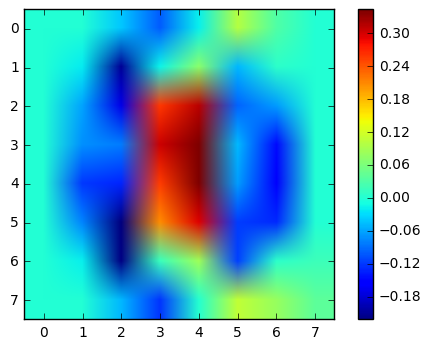

In [221]:
from sklearn.metrics import roc_auc_score

shared_weights.set_value(np.zeros(64, dtype='float64')) 

for i in range(10):
    loss_i = train_function(X_train, y_train)
#     print(shared_weights.get_value())
    print('loss at iter %i: %.4f' % (i, loss_i))
    print('train auc:', roc_auc_score(y_train, predict_function(X_train)))
    print('test auc:', roc_auc_score(y_test, predict_function(X_test)))

    
print('resulting weights: ')
plt.imshow(shared_weights.get_value().reshape(8, -1))
plt.colorbar()